PSEUDO CODE:

Algorithm: REINFORCE
### step 1 
Initialise parameters: step size 𝛼 ∈ (0,1]

### step 2 
Initialise policy network 𝜋 with parameters 𝜽

## Main loop 
### step 3 
For episode = 1, 𝑀 do

    Generate an episode trajectory 𝜏~𝜋𝜽

### step 4 

    For 𝑡 = 1, 𝑇 − 1 do

       G <- Sum of rewards

       𝜽 <- update parameters

    End For
    
End For (related to episode loop)


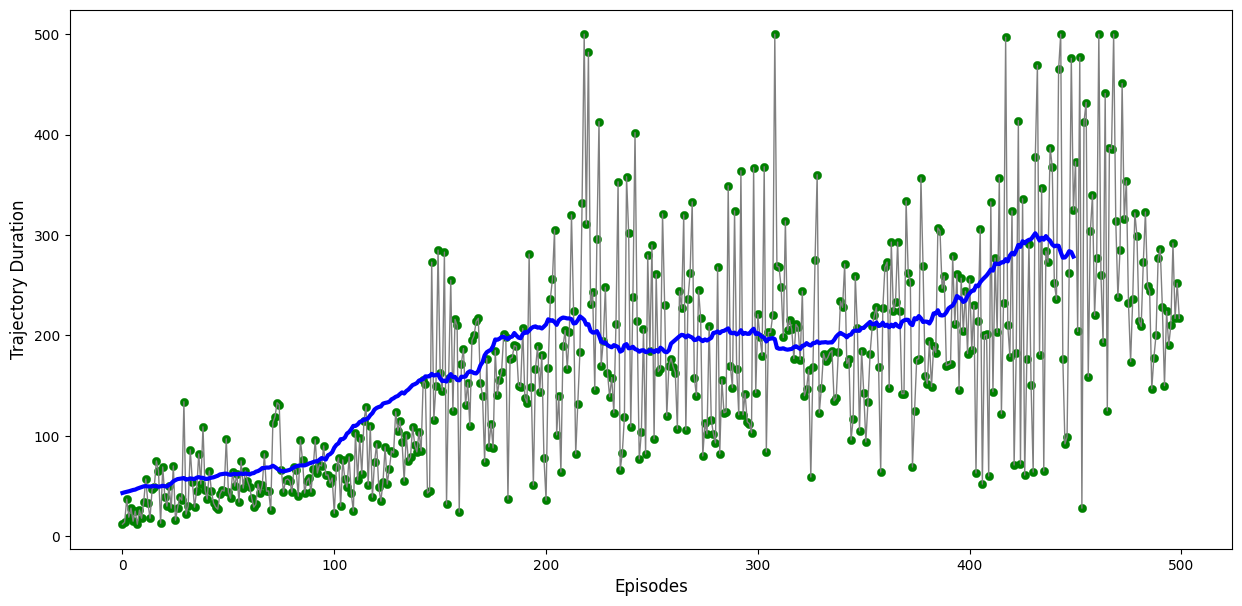

In [40]:
#Reinforce implementation on cartpole nn 64 64
import numpy as np
import torch
import gym
from matplotlib import pyplot as plt
import time



    
env = gym.make('CartPole-v0')



#STEP 2: Intialize NN 

obs_size = env.observation_space.shape[0] #Initialize number of observation inputs for NN
action_size = env.action_space.n  #Initialize number of actions for NN
hidden_layer_size = 256
#hidden_layer_size2 = 64


model = torch.nn.Sequential(
                    torch.nn.Linear(obs_size, hidden_layer_size),
                    torch.nn.ReLU(),
                    #torch.nn.Linear(hidden_layer_size, hidden_layer_size2),
                    #torch.nn.ReLU(),
                    torch.nn.Linear(hidden_layer_size, action_size),
                    torch.nn.Softmax(dim=0)
            )

#STEP 1: Initialize parameters etc.
learning_rate = 0.003 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
TRANSITONS = 500
Episodes = 500 #change to run for longer or shorter
gamma = 0.99
reward = []

#STEP 3: Gain a trajectory of experience 
for trajectory in range(Episodes): # Outer loop for generating trajectories
    curr_state = env.reset()[0] #Get current state
    
    done = False
    transitions = [] # list for transitions 
    
    for t in range(TRANSITONS): # loop to append each transition info into a list. 
        act_prob = model(torch.from_numpy(curr_state).float())
        action = np.random.choice(np.array([0,1]), 
                 p=act_prob.data.numpy())
        prev_state = curr_state
        #print(env.step(action))
        env.render()
        curr_state,_, done,_, info = env.step(action) 
        
        transitions.append((prev_state, action, t+1)) 
        if done: 
            break
    reward.append(len(transitions)) #The length of transitions indicates the total reward for cartpole.
    reward_batch = torch.Tensor([r for (s,a,r) in 
                   transitions]).flip(dims=(0,)) #flip the rewards in order to use discounting loop
    batch_Gvals =[]
    for i in range(len(transitions)): #this double loop discounts the rewards
        new_Gval=0
        power=0
        for j in range(i,len(transitions)):
             new_Gval=new_Gval+((gamma**power)*reward_batch[j]).numpy()
             power+=1
        batch_Gvals.append(new_Gval)

    #STEP 4: Calculate loss and update NN. 
    expected_returns_batch=torch.FloatTensor(batch_Gvals)
    expected_returns_batch /= expected_returns_batch.max() # normalize expected returns 
    state_batch = torch.Tensor([s for (s,a,r) in transitions]) 
    action_batch = torch.Tensor([a for (s,a,r) in transitions]) 
    pred_batch = model(state_batch) #get the probabilities for the states seen in the episode
    prob_batch = pred_batch.gather(dim=1,index=action_batch #get the probabilities associated with the given action taken for the state
                 .long().view(-1,1)).squeeze() 
    
    loss= -torch.sum(torch.log(prob_batch)*expected_returns_batch) #compute the loss as given by REINFORCE 
    
    optimizer.zero_grad() #clear the gradients in order to provide room for new gradients
    loss.backward() #calculate gradients.
    optimizer.step() #take step in the direction of new gradient.


def running_mean(x):
    N=50
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y
score = np.array(reward)
avg_score = running_mean(score)
plt.figure(figsize=(15,7))
plt.ylabel("Trajectory Duration",fontsize=12)
plt.xlabel("Episodes",fontsize=12)
plt.plot(score, color='gray' , linewidth=1)
plt.plot(avg_score, color='blue', linewidth=3)
plt.scatter(np.arange(score.shape[0]),score, 
            color='green' , linewidth=0.3)




In [100]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from gym.wrappers.record_video import RecordVideo


# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=256):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        action_probs = torch.softmax(self.fc2(x), dim=-1)
        return action_probs

# Reinforce algorithm
def reinforce(env, num_episodes, max_steps_per_episode, gamma=0.99, lr=0.001):
    policy_net = PolicyNetwork(state_size=env.observation_space.shape[0],
                               action_size=env.action_space.n)
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)

    episode_rewards_history = []
    last_episode_video_path = './'
    
    for episode in range(num_episodes):
        state = env.reset()[0]
        episode_rewards = []
        log_probs = []

        
        
        for step in range(max_steps_per_episode):


            state_tensor = torch.from_numpy(state).float().unsqueeze(0)
            action_probs = policy_net(state_tensor)
            action_dist = torch.distributions.Categorical(action_probs)
            action = action_dist.sample()
            log_prob = action_dist.log_prob(action)
            
            #print(env.step(action.item()))
            next_state, reward, done,_, _ = env.step(action.item())
            episode_rewards.append(reward)
            log_probs.append(log_prob)
            
            if done:
                break
                
            state = next_state
        
        if episode == num_episodes - 1:  # Record the last episode
            last_episode_video_path = f'last_episode_{episode}.mp4'
            env = RecordVideo(env, last_episode_video_path)
            for _ in range(step + 1):
                state_tensor = torch.from_numpy(state).float().unsqueeze(0)
                action_probs = policy_net(state_tensor)
                action_dist = torch.distributions.Categorical(action_probs)
                action = action_dist.sample()
                state, _, done, _ = env.step(action.item())
                if done:
                    break
            env.close()

        # Compute the discounted cumulative reward
        discounted_rewards = []
        R = 0
        for r in episode_rewards[::-1]:
            R = r + gamma * R
            discounted_rewards.insert(0, R)

        episode_rewards_history.append(sum(episode_rewards))
        
        # Normalize the discounted rewards
        discounted_rewards = torch.tensor(discounted_rewards)
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)
        
        # Compute the policy gradient and update the policy network
        policy_losses = []
        for log_prob, reward in zip(log_probs, discounted_rewards):
            policy_losses.append(-log_prob * reward)
        
        policy_loss = torch.stack(policy_losses).sum()
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
    env.close()   
    return policy_net, episode_rewards_history

# Train the policy network
env = gym.make('LunarLander-v2')
policy_net, episode_rewards_history = reinforce(env, num_episodes=1000, max_steps_per_episode=1000)



/Users/luisweekes/anaconda3/envs/myenv/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


KeyboardInterrupt: 

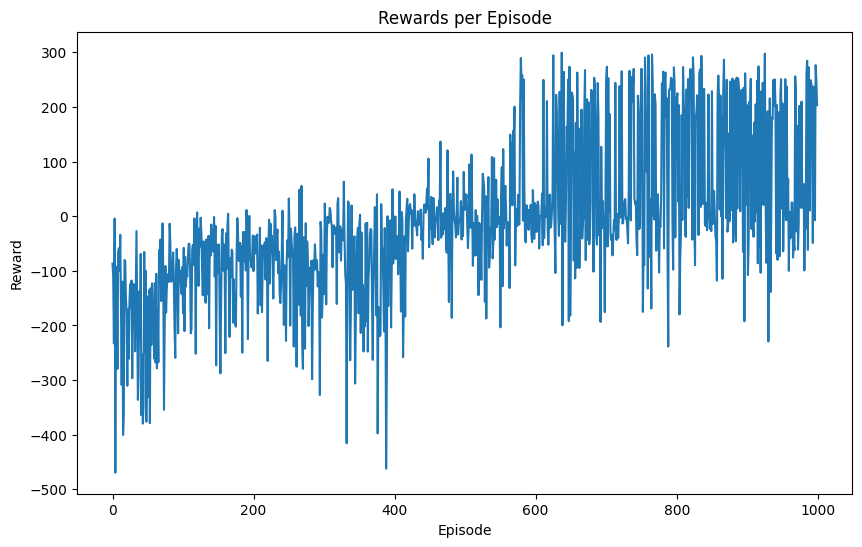

In [98]:
plt.figure(figsize=(10, 6))
plt.plot(episode_rewards_history)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()

In [82]:
!pip install box2d box2d-kengz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.4/425.4 kB 7.6 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-kengz: filename=Box2D_kengz-2.3.3-cp311-cp311-macosx_11_0_arm64.whl size=390365 sha256=5715b78100a81b957a2795276473eca1a4d311e2957a69e589258e7876e5c626
  Stored in directory: /Users/luisweekes/Library/Caches/pip/wheels/52/6a/a7/b49372347210a86f54c6603329c24c48dba26c98586ae80fbb
Successfully built box2d-kengz


In [79]:
!pip install swig


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.5 MB/s eta 0:00:00a 0:00:01


In [ ]:
!pip install box2d pygame